In [ ]:
#imports
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from sklearn.utils import resample
import progressbar
import warnings
warnings.filterwarnings('ignore')

# Exercise Set 13: Network formation


In this Exercise Set 13 we will investigate network formation among high school pupils. 

## Part 1: Network formation


Load the data using the script below. Read a bit about the dataset [here](http://www.sociopatterns.org/datasets/high-school-contact-and-friendship-networks/) to get an understanding of what is in each variable. 

The script gives you two dataframes to work with: 
 > `el`, which is an edge-list 
 >
 > `ind` which contains individual characteristics

In [2]:
import networkx as nx
import numpy as np
import pandas as pd

url_base = 'http://www.sociopatterns.org/wp-content/uploads/2015/'

# edgelist
url_el = url_base + '07/High-School_data_2013.csv.gz'
col_names_el = ['timestamp', 'u1', 'u2', 'class1', 'class2']
el = pd.read_csv(url_el, header=None, names=col_names_el, delimiter=' ')

# individual characteristics
url_ind = url_base + '09/metadata_2013.txt'
col_names_ind = ['u', 'class', 'gender']
ind = pd.read_csv(url_ind, header=None, names=col_names_ind, delimiter='\t')\
            .set_index('u')

# remove observation with missing gender
has_gender = ind[ind.gender!='Unknown'].index

# DataFrames
ind = ind.loc[has_gender].copy()
el = el[el.u1.isin(has_gender) &  el.u2.isin(has_gender)].copy()

> **Ex. 13.1.1**: Describe the edgelist columns content. Parse the timestamp. What is the resolution of meetings? Use the parsed timestamp to count the meetings by hour in local time.

In [3]:
#answer to 13.1.1
el

,timestamp,u1,u2,class1,class2
0,1385982020,454,640,MP,MP
1,1385982020,1,939,2BIO3,2BIO3
2,1385982020,185,258,PC*,PC*
3,1385982020,55,170,2BIO3,2BIO3
4,1385982020,9,453,PC,PC
...,...,...,...,...,...
188503,1386345560,120,285,PC,PC
188504,1386345580,61,160,2BIO2,2BIO2
188505,1386345580,272,939,2BIO3,2BIO3
188506,1386345580,311,496,PC,PC


In [4]:
# Time is measured in seconds and expressed in Unix ctime.
el["timestamp"]=pd.to_datetime(el["timestamp"],unit='s')

#count number of meetings by hour
meetings = el.groupby(pd.Grouper(key="timestamp",freq="h")).size().reset_index(name="meetings")
meetings

,timestamp,meetings
0,2013-12-02 11:00:00,5556
1,2013-12-02 12:00:00,4259
2,2013-12-02 13:00:00,6617
3,2013-12-02 14:00:00,5715
4,2013-12-02 15:00:00,5972
...,...,...
96,2013-12-06 11:00:00,4106
97,2013-12-06 12:00:00,3247
98,2013-12-06 13:00:00,1785
99,2013-12-06 14:00:00,2026


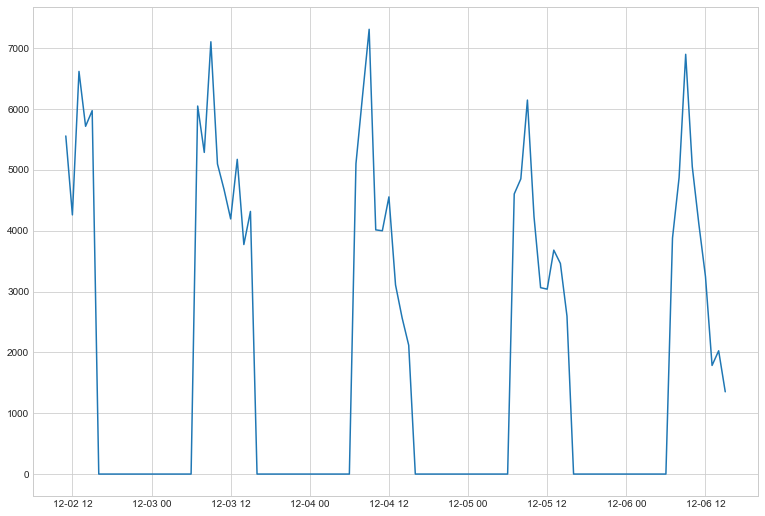

In [5]:
fig = plt.figure(figsize=(13,9))
ax = fig.add_subplot(111)
ax.plot(meetings.timestamp,meetings.meetings)

The figure above shows the number of meetings throught the five days in december 2013. The number of meetings spikes during school hours and drops to zero after school. 

> **Ex. 13.1.2**: Count the number of meetings for each edge and save this as a DataFrame called `el_agg`. Filter out edges with less than 5 minutes of meetings. Attach the gender and class of both nodes.

In [6]:
#Answer to 13.1.2

el_agg = el.groupby([el.timestamp.dt.minute >5,el.u1,el.u2]).size().reset_index(name="meetings").drop(["timestamp"],axis=1)
el_agg = el_agg.merge(ind, right_index=True,left_on=["u1"]).rename(columns={"class":"u1_class","gender":"u1_gender"})
el_agg = el_agg.merge(ind, right_index=True,left_on=["u2"]).rename(columns={"class":"u2_class","gender":"u2_gender"}).reset_index().drop(["index"],axis=1)
el_agg

,u1,u2,meetings,u1_class,u1_gender,u2_class,u2_gender
0,1,55,2,2BIO3,M,2BIO3,F
1,1,55,6,2BIO3,M,2BIO3,F
2,1,63,1,2BIO3,M,2BIO3,F
3,1,63,1,2BIO3,M,2BIO3,F
4,3,63,2,2BIO2,M,2BIO3,F
...,...,...,...,...,...,...,...
7497,1212,1232,6,MP*2,M,MP*2,M
7498,1214,1232,10,MP*2,M,MP*2,M
7499,1216,1232,1,MP*2,M,MP*2,M
7500,1228,1232,57,MP*2,M,MP*2,M


> **Ex. 13.1.3**: Answer question in the function `fraction_triangles` below. Explain how `fraction_triangles` is related to  computing the clustering coefficient (using `nx.average_clustering`).
>
>> *Hint:* The following code does the same thing as `fraction_triangles`, but at a scale where you can understand what's going on. If you have a hard time understanding the code in the function you can try to play around with this simpler example
>>
>> ```python
>> import networkx as nx 
>>
>> A  = np.array(
>>     [[0, 1, 1, 0],
>>      [1, 0, 1, 0],
>>      [1, 1, 0, 1],
>>      [0, 0, 1, 0]]
>> )
>>
>> G = nx.from_numpy_array(A)
>> nx.draw(G,with_labels=True)
>>
>> def nth(A, n):
>>     A_ = A.copy()    
>>     for _ in range(1,n):
>>         A = A.dot(A_)
>>     return A
>>
>> a_t = nth(A,3).diagonal().sum()/6
>> n = len(A[:,0])
>> p_t = binom(n, 3)
>> ```


In [7]:
def make_net(el_, nodes):
    '''
    Convert edgelist to networkx graph which is 
    binary and undirected.
    
    Parameters
    ----------
    el_ : DataFrame
        Table containing an edgelist with columns 
        `u1` and `u2` which are the nodes in the edge.
        
    nodes : array-like
        1d array containing the node identities.
    '''    
    
    nx_input = el_, 'u1', 'u2','meetings', nx.Graph()
    g = nx.from_pandas_edgelist(*nx_input)
    g.add_nodes_from(nodes)
    return g

In [8]:
from scipy.special import binom

def fraction_triangles(el_, nodes):
    '''
    Compute fraction of actual triangles out 
    of the potential triangles.
    
    Parameters
    ----------
    el_ : DataFrame
        Table containing an edgelist with columns 
        `u1` and `u2` which are the nodes in the edge.
        
    nodes : array-like
        1d array containing the node identities.
    '''
    
    g = make_net(el_, nodes)
    
    #Q.1: what is `A`?: the adjacency matrix which is symmetric and binary
    #Q.2: what does `A**3` do? compute the number of paths between two nodes
    #Q.3: what is diagonal of A_t? the number of actual paths of length 3, 
    # i.e. triangles, which include the person. these are called cycles
    # because they start and end at the same person
    
    # count actual triangles    
    A = nx.to_scipy_sparse_matrix(g)
    A_t = A**3
    a_t = A_t.diagonal().sum()/6
    
    #Q.4: what does `binom(n,3)` compute? the number of triangles including the person
    
    # count potential triangles
    n = len(g.nodes())
    p_t = binom(n, 3)
        
    return a_t/p_t

> **Ex. 13.1.4**: Apply the function `fraction_triangles` to `el_agg` and print the triangle fraction in the network. Next remove all edges that go between classes. Compute triangle fraction within each class and store it. Compute the mean within class triangles and bootstrap the standard error of the mean. Comment on the output.
>
>> *Hint:* To bootstrap an estimate draw $k>>0$ samples with replacement from the data. Compute the estimate on each of these samples and average them in the end to get the bootstrapped estimate. 

In [16]:
# answer to 13.1.4

def nodes(df):
    """
    compute a list containing node identities 
    
    Args:
    df (DataFrame): Table containing an edgelist with columns `u1` and `u2` which are the nodes in the edge.
    
    Returns:
    nodes_ (list): list of unique node identities sorted in ascending order.
    
    """
    
    nodes_ = sorted(df.u1.unique().tolist()+df.u2.unique().tolist())
    return nodes_

def mean_class_triangles(df):
    """
    compute the triangle fraction within each class and returns the mean.
    
    Args:
    df (DataFrame): Table containing an edgelist with columns `u1` and `u2` which are the nodes in the edge.
    
    Returns:
    np.mean(frac_triang_class) (float): mean within class triangles
    
    """
    #initialize storage
    frac_triang_class = np.empty(len(df.u1_class)) 
    
    for i,c in enumerate(df.u1_class):
        # removing edges that go between classes
        sample_class = el_agg.loc[(el_agg["u1_class"]==c) & (el_agg["u1_class"]==el_agg["u2_class"])]
        class_nodes = nodes(sample_class) #computing class nodes 
        frac_triang_class[i] = fraction_triangles(sample_class,class_nodes)
    return np.mean(frac_triang_class)

def bootstrap(df,n_iter,bootstraps):
    """
    compute the bootstrapped std. error of the mean
    
    Args:
    df (DataFrame): Table containing an edgelist with columns `u1` and `u2` which are the nodes in the edge.
    n_iter (int): Number of iterations
    bootstraps (int): number of samples 
    
    Returns:
    np.std(mean) (float): The bootstrapped std. error of the mean
    """
    #initializing storage
    mean = np.empty(n_iter)
    
    for i,_ in enumerate(progressbar.progressbar(range(n_iter))):
        sample_df = resample(df,n_samples=bootstraps,stratify=df) #resampling DataFrame. Data is stratified.
        mean[i] = mean_class_triangles(sample_df)
    return np.std(mean)

In [11]:
# full network

nodes_full = nodes(el_agg)
frac_triang_full = fraction_triangles(el_agg,nodes_full)
print(f'The fraction of triangles in the full network is: {frac_triang_full}')

The fraction of triangles in the full network is: 0.005962397231915774


In [12]:
# within class network

frac_triang_class = mean_class_triangles(el_agg)
print(f'The mean fraction of triangles within classes is: {frac_triang_class}')

The mean fraction of triangles within classes is: 0.39643753319148023


In [17]:
# bootstrapping

n_iter = 1000
bootstraps = 20

bootstrap_std = bootstrap(el_agg,n_iter,bootstraps)
print(f'The bootstrapped std. error of the mean is: {bootstrap_std:.10f}')

100% (1000 of 1000) |####################| Elapsed Time: 0:05:22 Time:  0:05:22


The bootstrapped std. error of the mean is: 0.0163686224


Recall from class that we can define the following measures of homophily. We define **homophily index** inspired by [Currarini et al. (2009)](https://doi.org/10.2139/ssrn.1021650):
- share of edges that are same type: $H = \frac{s}{s+d}$
- possible range [0,1]


We define **baseline homophily** as: 
- We count fraction of potential edges in population of nodes which are same type:

\begin{equation}B=\frac{\sum_t\#potential(n_t)}{\#potential(n)}, \qquad \#potential(k)=\frac{k\cdot(k-1)}{2}\end{equation}

- Interpretation: Expected homophily from random link formation.     

We define **inbreeding homophily** as:      

\begin{equation}IH=\frac{H-B}{1-B}\end{equation}


> **Ex. 13.1.5**: Compute the inbreeding homophily for each class. Use the class measures to compute the mean. Use a bootstrap to compute whether there is inbreeding homophily.

In [18]:
def hom_index(df):
    df["gender_sorting"] = df.u1_gender==df.u2_gender
    df["gender_sorting"] = df["gender_sorting"].astype(int)
    H = np.sum(df.gender_sorting==1)/np.shape(df)[0]
    return H

def baseline_hom(df):
    k = ind.gender.value_counts()
    same_gender_edges = (k[0]*(k[0]-1)+k[1]*(k[1]-1))/2
    total_edges = ((k[0]+k[1])*((k[0]+k[1])-1))/2
    B = same_gender_edges / total_edges
    return B

def inbreeding_hom(df):
    H = hom_index(df)
    B = baseline_hom(df)
    IH = (H-B)/(1-B)
    return IH 

In [30]:
def mean_class_hom(df):
    class_inbreed = np.empty(len(df.u1_class))

    for i,c in enumerate(df.u1_class):
        # removing edges that go between classes
        sample_class = el_agg.loc[(el_agg["u1_class"]==c) & (el_agg["u1_class"]==el_agg["u2_class"])]
        class_inbreed[i] = inbreeding_hom(sample_class)
    return np.mean(class_inbreed)

def bootstrap_hom(df,n_iter,bootstraps):
    mean_hom = np.empty(n_iter)
    
    for i,_ in enumerate(progressbar.progressbar(range(n_iter))):
        sample_df = resample(df,n_samples=bootstraps) #resampling DataFrame. Data is stratified.
        mean_hom[i] = mean_class_hom(sample_df)>=0
    return np.std(mean_hom)

In [31]:
# inbreeding homophily in class
mean_hom = mean_class_hom(el_agg)
print(f'The mean of inbreeding homophily within classes is: {mean_hom}')

The mean of inbreeding homophily within classes is: 0.22220007609769651


In [34]:
#Bootstrapping
n_iter = 1000
bootstraps = 20

hom_bootstrap_std = bootstrap_hom(el_agg,n_iter,bootstraps)
print(f'The bootstrapped std. error of the mean is: {hom_bootstrap_std}')

100% (1000 of 1000) |####################| Elapsed Time: 0:01:08 Time:  0:01:08


The bootstrapped std. error of the mean is: 0.0


> **Ex. 13.1.6** (BONUS): Describe what an unsupported edge is. Construct a test of whether there is a preference for forming  triangles within same gender than across.
>
>> *Hint:*  You can find inspiration in the approach of [Chandrasekhar, Jackson (2018)](https://web.stanford.edu/~arungc/CJ_sugm.pdf) pp. 31-35. They construct an almost identical test for triangle formation across castes in Indian villages.

In [ ]:
# [Answer to ex. 13.1.6 here]